# Initial

In [0]:
!pip -q install "dask[complete]"

In [0]:
!pip -q install "dask-ml[complete]"

In [0]:
!pip -q install --upgrade --ignore-installed numpy pandas scipy sklearn

In [0]:
# https://stackoverflow.com/questions/49853303/how-to-install-pydot-graphviz-on-google-colab?rq=1
!pip -q install graphviz 
!apt-get install graphviz -qq
!pip -q install pydot

In [0]:
#!pip -q install bokeh

# Import

In [0]:
import numpy as np
import pandas as pd
import dask.array as da
import graphviz

In [0]:
import matplotlib.pyplot as plt

# 2. Data Types

### a) Array:

In [29]:
arr = np.random.randint(1, 1000, (1000, 1000))
darr = da.from_array(arr, chunks=(250, 250))
darr

dask.array<array, shape=(1000, 1000), dtype=int64, chunksize=(250, 250)>

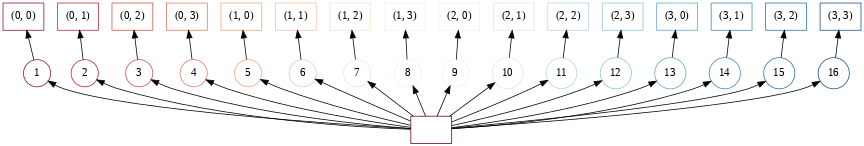

In [53]:
darr.visualize(color="order", size="9,10!")

In [30]:
darr.chunks, darr.chunksize, darr.npartitions

(((250, 250, 250, 250), (250, 250, 250, 250)), (250, 250), 16)

In [0]:
res = darr.sum(axis=0)

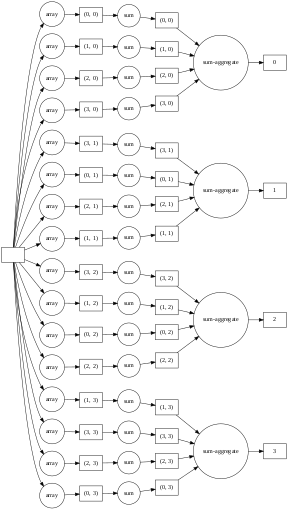

In [48]:
res.visualize(rankdir="LR", size="3,20!") # Graph of methods we applied
# If we have a graph structure with many independent nodes per level in our implementation, Dask will be able to 
# parallelize it and we will get speedup, if our problem is sufficiently large.

In [55]:
res.compute().shape

(1000,)

In [0]:
def numpy_mean(size=(10, 10)):
  arr = np.random.random(size=size)
  return arr.mean()

def dask_mean(size=(10, 10)):
  if size[0] > 10000: chunks = (1000, 1000)
  else: chunks = (int(size[0]/10), int(size[1]/10))
  
  arr = da.random.random(size=size, chunks=chunks)
  y = arr.mean()
  return y.compute()

In [0]:
import time

def dask_arr_chk():
  sizes = []
  times = []
  size = 10
  for i in range(5):
    dim1 = size ** (i+1)
    for j in range(4):
      dim2 = size ** (j+1)
      if dim1*dim2 in sizes: continue
      st = time.time()
      dask_mean(size=(dim1, dim2))
      en = time.time()
      sizes.append(dim1*dim2)
      times.append(en-st)
  return sizes, times

def numpy_arr_chk():
  sizes = []
  times = []
  size = 10
  for i in range(4):
    dim1 = size ** (i+1)
    for j in range(4):
      dim2 = size ** (j+1)
      if dim1*dim2 in sizes: continue
      st = time.time()
      numpy_mean(size=(dim1, dim2))
      en = time.time()
      sizes.append(dim1*dim2)
      times.append(en-st)
  return sizes, times

In [81]:
%%time
x1, y1 = numpy_arr_chk()
x2, y2 = dask_arr_chk()

CPU times: user 37 s, sys: 2.84 s, total: 39.8 s
Wall time: 23.1 s


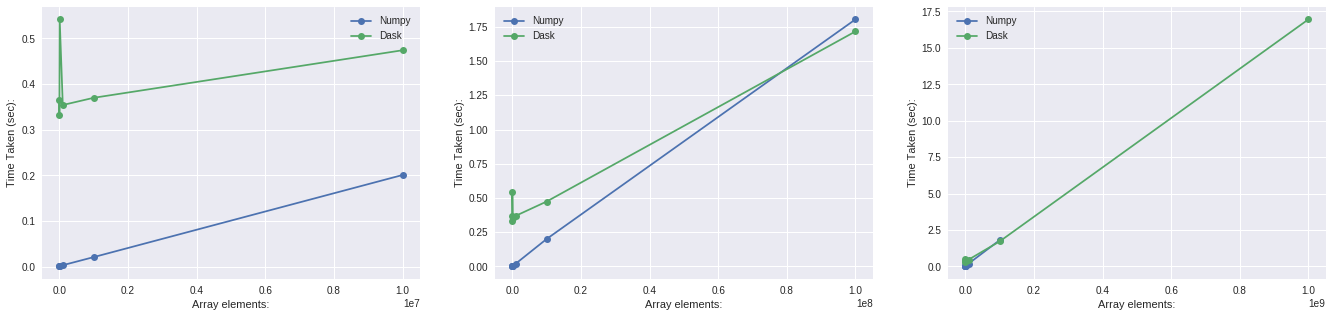

In [85]:
fig, axs = plt.subplots(1, 3, figsize=(23, 5))
axs[0].plot(x1[:-1], y1[:-1], "o-", label="Numpy")
axs[0].plot(x2[:-2], y2[:-2], "o-", label="Dask")
axs[0].set_xlabel("Array elements:")
axs[0].set_ylabel("Time Taken (sec):")
axs[0].legend()

axs[1].plot(x1, y1, "o-", label="Numpy")
axs[1].plot(x2[:-1], y2[:-1], "o-", label="Dask")
axs[1].set_xlabel("Array elements:")
axs[1].set_ylabel("Time Taken (sec):")
axs[1].legend()

axs[2].plot(x1, y1, "o-", label="Numpy")
axs[2].plot(x2, y2, "o-", label="Dask")
axs[2].set_xlabel("Array elements:")
axs[2].set_ylabel("Time Taken (sec):")
axs[2].legend()

In low dimensions, numpy is taking less time than Dask because Dask has to create many processes for the number of workers we set during definition of *Client* declaration (Fig 1). But as number of array elements increases we see that Dask takes less time than Numpy (Fig 2). Beyond that numpy is not able to compute because it is not able to bring whole array into memory, but Dask is able to by computings many blocks in sequential order. (Fig 3).

### b) DataFrame:

In [0]:
import dask.dataframe as dd
import numpy as np
import gc
gc.enable()

In [14]:
arr = np.random.normal(0.0, 1.0, size=(1000000, 10))
df = dd.from_array(arr, chunksize=50000, columns=[f"col-{i+1}" for i in range(10)])
del arr
gc.collect()

239

In [15]:
df

,col-1,col-2,col-3,col-4,col-5,col-6,col-7,col-8,col-9,col-10
npartitions=20,,,,,,,,,,
0,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
50000,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
950000,...,...,...,...,...,...,...,...,...,...
999999,...,...,...,...,...,...,...,...,...,...


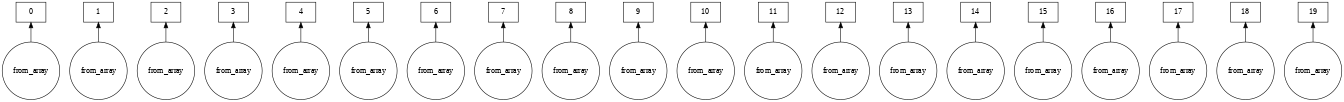

In [22]:
df.visualize(size="14,16!")

In [23]:
df.head() # Not lazy beacuse it doesn't take much computation

,col-1,col-2,col-3,col-4,col-5,col-6,col-7,col-8,col-9,col-10
0,-0.670259,0.130116,1.245027,-1.136380,-0.470103,-0.941553,-1.671139,0.145971,2.293270,0.155823
1,-0.257975,1.908346,-1.550921,-0.457190,-2.577153,-1.934383,-1.645623,-0.591864,1.537130,-2.281100
2,-0.054823,-0.088429,1.380285,0.308579,0.633180,0.193406,0.304017,-1.595323,-0.491884,-0.622066
3,1.232906,1.088529,1.100429,1.195908,1.054931,0.169908,-0.811806,0.355700,1.353377,-0.301842
4,0.664006,-0.243633,-0.429093,-0.274839,2.432883,-0.425719,1.071818,-1.019423,0.236055,1.932841


In [24]:
df.tail()

,col-1,col-2,col-3,col-4,col-5,col-6,col-7,col-8,col-9,col-10
49995,0.247672,0.936369,-1.096501,-0.119473,-0.742709,-1.262157,2.804558,0.123460,-2.267689,-1.635113
49996,1.952103,-0.023558,0.322716,-1.819625,-1.068469,0.395161,-0.089166,0.901499,-1.213241,0.034917
49997,0.217870,0.198978,0.201295,-1.231125,-0.464736,1.505220,1.805124,-0.508538,-0.257614,-1.761602
49998,-0.101036,-0.366966,1.170377,0.325161,-2.288755,1.238234,-1.171790,-1.514991,0.647966,0.392074
49999,1.229795,-1.739559,0.374630,0.652674,0.122733,-1.720617,-1.272090,0.783040,-0.327491,-0.183753


In [0]:
df["col-1"] = (df["col-1"]*10).astype(int)

In [0]:
agg = df.groupby(by=["col-1"]).aggregate(["sum", "std", "max", "min", "mean"])

In [51]:
agg.head(2)

col-2                                       col-3                \
            sum std       max       min      mean       sum std       max   
col-1                                                                       
-500   1.048068 NaN  1.048068  1.048068  1.048068  1.437503 NaN  1.437503   
-490   0.519506 NaN  0.519506  0.519506  0.519506  1.322778 NaN  1.322778   

                             ...        col-9                          \
            min      mean    ...          sum std       max       min   
col-1                        ...                                        
-500   1.437503  1.437503    ...    -0.720701 NaN -0.720701 -0.720701   
-490   1.322778  1.322778    ...    -0.941289 NaN -0.941289 -0.941289   

                   col-10                                    
           mean       sum std       max       min      mean  
col-1                                                        
-500  -0.720701 -0.544602 NaN -0.544602 -0.544602 -0.544602  
-490  -0.941289 -0.099877 NaN -0.099877 -0.099877 -0.099877  

[2 rows x 45 columns]

In [52]:
columns = []
for col in agg.columns.levels[0]:
  for a in agg.columns.levels[1]:
    columns.append(f"{col}.{a}")

agg.columns = columns
agg.head(2)

,col-10.max,col-10.mean,col-10.min,col-10.std,col-10.sum,col-2.max,col-2.mean,col-2.min,col-2.std,col-2.sum,...,col-8.max,col-8.mean,col-8.min,col-8.std,col-8.sum,col-9.max,col-9.mean,col-9.min,col-9.std,col-9.sum
col-1,,,,,,,,,,,,,,,,,,,,,
-500,1.048068,NaN,1.048068,1.048068,1.048068,1.437503,NaN,1.437503,1.437503,1.437503,...,-0.720701,NaN,-0.720701,-0.720701,-0.720701,-0.544602,NaN,-0.544602,-0.544602,-0.544602
-490,0.519506,NaN,0.519506,0.519506,0.519506,1.322778,NaN,1.322778,1.322778,1.322778,...,-0.941289,NaN,-0.941289,-0.941289,-0.941289,-0.099877,NaN,-0.099877,-0.099877,-0.099877


In [0]:
df_new = df.merge(agg.reset_index(), how="left", on="col-1")

In [54]:
df_new

,col-1,col-2,col-3,col-4,col-5,col-6,col-7,col-8,col-9,col-10,col-10.max,col-10.mean,col-10.min,col-10.std,col-10.sum,col-2.max,col-2.mean,col-2.min,col-2.std,col-2.sum,col-3.max,col-3.mean,col-3.min,col-3.std,col-3.sum,col-4.max,col-4.mean,col-4.min,col-4.std,col-4.sum,col-5.max,col-5.mean,col-5.min,col-5.std,col-5.sum,col-6.max,col-6.mean,col-6.min,col-6.std,col-6.sum,col-7.max,col-7.mean,col-7.min,col-7.std,col-7.sum,col-8.max,col-8.mean,col-8.min,col-8.std,col-8.sum,col-9.max,col-9.mean,col-9.min,col-9.std,col-9.sum
npartitions=20,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


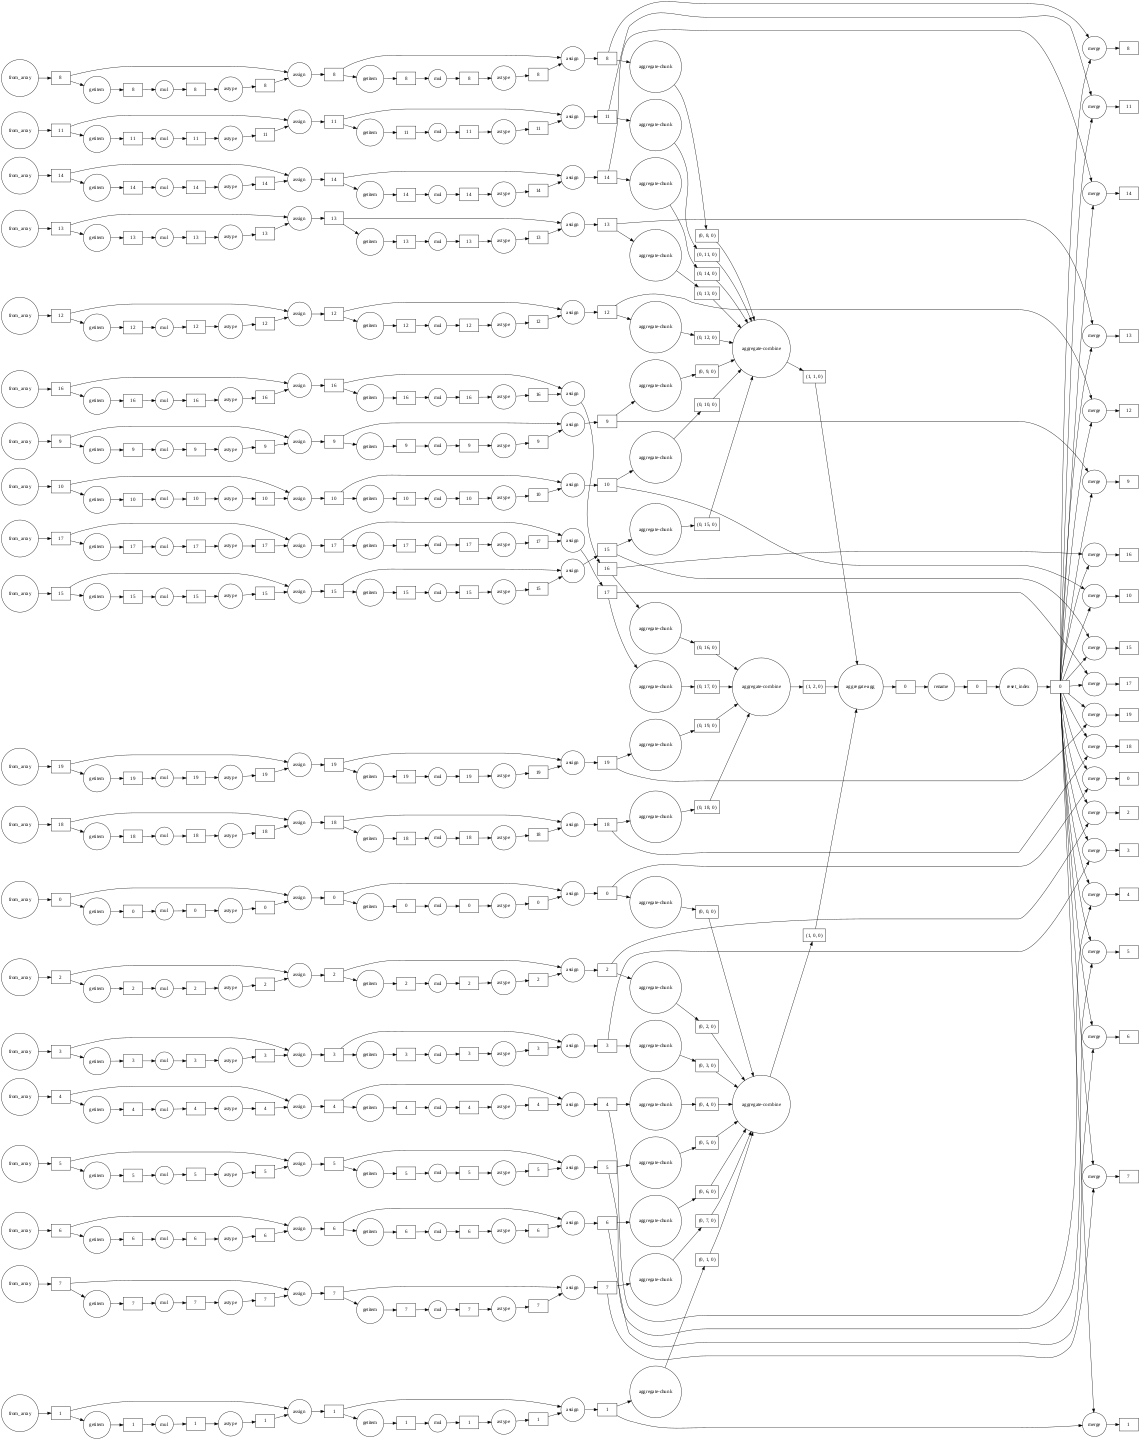

In [63]:
df_new.visualize(rankdir="LR", size="20, 15!")

In [64]:
df_new.compute().head()

,col-1,col-2,col-3,col-4,col-5,col-6,col-7,col-8,col-9,col-10,...,col-8.max,col-8.mean,col-8.min,col-8.std,col-8.sum,col-9.max,col-9.mean,col-9.min,col-9.std,col-9.sum
0,-60,0.130116,1.245027,-1.136380,-0.470103,-0.941553,-1.671139,0.145971,2.293270,0.155823,...,-436.763233,0.998168,3.957593,-3.943839,-0.013558,-298.565293,0.993525,3.915293,-4.024406,-0.009268
1,-20,1.908346,-1.550921,-0.457190,-2.577153,-1.934383,-1.645623,-0.591864,1.537130,-2.281100,...,170.245958,1.006248,4.544046,-4.234739,0.004340,158.471773,0.996160,3.838703,-3.834235,0.004040
2,0,-0.088429,1.380285,0.308579,0.633180,0.193406,0.304017,-1.595323,-0.491884,-0.622066,...,-91.181243,1.004919,4.289157,-4.790374,-0.001144,-274.389036,1.000430,3.920591,-4.156023,-0.003441
3,120,1.088529,1.100429,1.195908,1.054931,0.169908,-0.811806,0.355700,1.353377,-0.301842,...,-128.199559,0.993309,3.978109,-3.946863,-0.007043,-15.423090,1.010217,4.344170,-3.792479,-0.000847
4,60,-0.243633,-0.429093,-0.274839,2.432883,-0.425719,1.071818,-1.019423,0.236055,1.932841,...,-116.715633,0.998924,4.284917,-4.321277,-0.003632,-197.993101,1.005309,4.386022,-4.163965,-0.006161


In [68]:
df_new.shape[0].compute(), df_new.shape[1]

(1000000, 55)

### c) Bag:

In [71]:
import dask.bag as db

lst = []
for i in range(5):
  lst.append({f"Name.{name}": value for name, value in np.random.randint(1, 10, (5, 2))})
  lst.append(np.random.randint(2, 5, (2, 4)))
  lst.append(np.random.randint(1, 1000, (1,)))
  lst.append([i for i in range(100, 200, 10)])
  
b = db.from_sequence(lst)
b.take(1)

({'Name.1': 5, 'Name.2': 4, 'Name.3': 4, 'Name.5': 6, 'Name.8': 4},)

In [0]:
def fil(el):
  if type(el)!=dict and type(el)!=list: return True
  else: return False

filmap = b.filter(fil).map(lambda x: x**2)

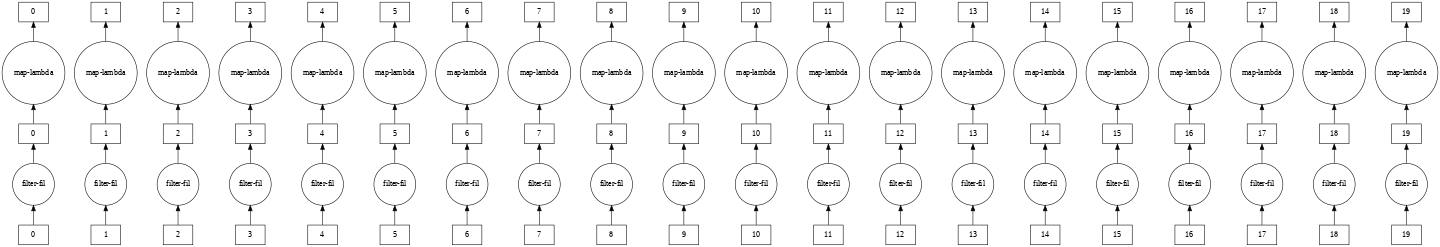

In [80]:
filmap.visualize(size="15,10!")

In [81]:
filmap.compute()

[array([[16, 16,  4,  9],
        [ 9,  9,  9,  9]]), array([144]), array([[ 4,  9,  9, 16],
        [ 9, 16,  9,  9]]), array([81]), array([[ 4, 16,  4,  9],
        [ 9,  9, 16, 16]]), array([422500]), array([[16,  4, 16,  9],
        [16,  9,  4, 16]]), array([15376]), array([[ 4,  9, 16,  9],
        [ 4,  9,  9,  9]]), array([62500])]

In [0]:
comp = filmap.flatten().mean()

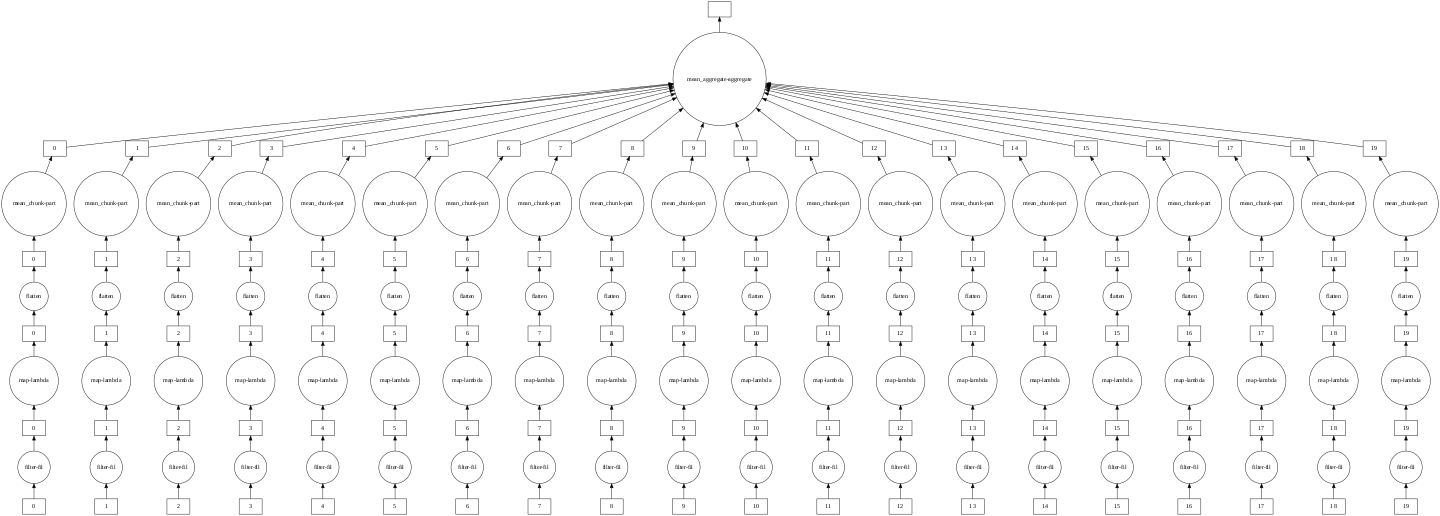

In [89]:
comp.visualize(size="15, 15!")

In [90]:
comp.compute()

array([33379.46666667, 33380.46666667, 33379.8       , 33380.8       ])

# 3. Delayed

In [0]:
import dask.delayed as delay

@delay
def sq(x):
  return x**2

@delay
def add(x, y):
  return x+y

@delay
def sum(arr):
  sum = 0
  for i in range(len(arr)): sum+=arr[i]
  return sum

In [103]:
# Adding tasks here is like adding nodes to graphs.
# You can add new taks based on results of prevoius tasks.
# Dask won't compute them right away. It will make a graph as
# you call them. And then COmpute the whole graph parallely.
lst = list(np.arange(1, 11))

for i in range(3):
  temp = []
  if i == 0:
    for j in range(0, len(lst)):
      temp.append(sq(lst[j]))
  elif i == 1:
    for j in range(0, len(lst)-1, 2):
      temp.append(add(lst[j], lst[j+1]))
  else:
    temp.append(sum(lst))
  lst = temp # New functions will be computed on last results
  
lst

[Delayed('sum-50855d18-12ab-45b0-827f-811f76ef4f61')]

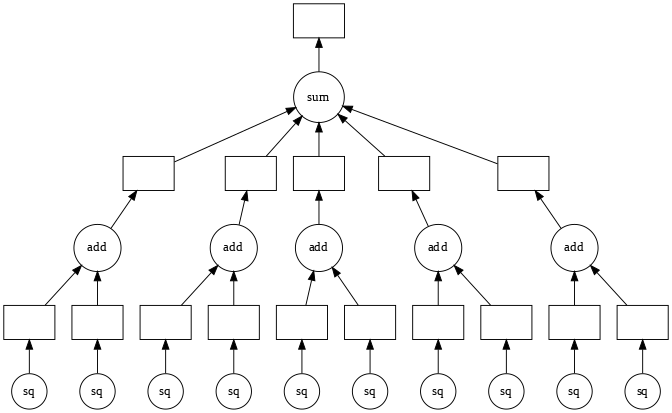

In [108]:
lst[0].visualize(size="7,10!")

In [111]:
lst[0].compute()

385

# 4. Distributed

In [0]:
from dask.distributed import Client, LocalCluster # Look into parameters of LocalCluster for arguments used

In [10]:
client = Client(processes=False, threads_per_worker=4, n_workers=4, memory_limit='8GB')
client

Client Scheduler: inproc://172.28.0.2/465/1,Cluster Workers: 4 Cores: 16 Memory: 32.00 GB


In [0]:
def sq(x):
  return x**2

inputs = np.arange(0, 10000000)

In [133]:
sent = client.submit(sq, 1000000)
sent # Pending: Not Complete

<Future: status: pending, key: sq-d1a659539d100f976e25945aee7760fa>

In [134]:
sent # Finished (after a few sec): Complete 

<Future: status: finished, type: int, key: sq-d1a659539d100f976e25945aee7760fa>

In [135]:
result = sent.result()
result

1000000000000

In [137]:
sent = client.submit(sq, inputs,)
sent

<Future: status: pending, key: sq-beea97dab1c0f976e630b1019463e80d>

In [138]:
sent

<Future: status: finished, type: ndarray, key: sq-beea97dab1c0f976e630b1019463e80d>

In [139]:
sent.result()

array([             0,              1,              4, ...,
       99999940000009, 99999960000004, 99999980000001])

# 5. Machine Learning

## Using Sklearn's Estimators:

### a) Regression: 

In [0]:
from dask_ml.datasets import make_regression
import dask.dataframe as dd

X, y = make_regression(n_samples=1e6, chunks=50000)

In [11]:
df = dd.from_dask_array(X)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.636006,1.580450,-0.231167,-1.076593,-1.799313,-0.212883,-1.248673,-0.097924,0.592198,1.973360,-0.633778,2.069049,-0.513082,0.279007,-1.240250,-1.288428,-1.287853,2.148110,0.703702,-0.513750,0.918279,0.511236,-1.645222,-1.153570,-0.009842,-0.606427,0.864412,2.146928,-1.257038,1.011320,-0.784774,-0.637251,-0.550073,0.698038,1.081563,1.334578,0.324886,0.835885,0.466519,0.395182,...,0.125635,-0.929155,-0.482454,-0.432708,1.415750,0.804679,-2.012812,-0.198452,-0.474623,0.580580,0.551024,0.171507,0.218519,1.154371,-1.112476,0.716686,-1.427311,-0.500832,0.201738,0.524525,0.641213,-1.105972,0.457081,-0.686895,0.103748,-1.146406,1.290764,-1.213358,-1.682367,-0.406284,0.767007,-0.830960,-0.262205,-0.232905,2.198081,-1.038331,0.418302,-1.069708,-1.300864,-0.314849
1,0.450114,0.127876,0.206091,1.806874,-0.311983,0.899294,2.550579,-0.406170,-0.258958,0.537336,0.900318,1.139114,0.664430,-0.138731,-0.592394,-0.622786,0.215034,-1.447936,1.413846,-1.483230,0.145964,-0.079164,-0.356865,1.089975,-0.575564,-0.282648,-0.293385,-1.498559,0.273455,1.001175,1.329964,1.191545,-0.288777,2.184004,-0.342577,0.532319,0.373763,-1.104663,1.707809,0.200237,...,-0.552751,1.864301,0.291355,0.427459,-1.632389,0.608134,1.286900,-0.546082,-1.606457,-1.123421,1.670265,-0.383822,-1.693053,-0.973753,-0.302651,0.177189,1.417356,0.344083,0.004315,3.068726,0.354205,0.106640,-1.222237,-1.297093,0.129487,0.069056,0.761077,-0.598765,0.296913,0.301375,-1.359498,-0.130784,2.267631,-1.177797,-0.656518,-1.388511,0.242812,-0.331910,0.561680,-0.489173
2,2.252202,0.285656,2.071482,-1.129784,0.577413,0.215880,0.114716,-0.995628,1.121539,-0.741294,1.191214,-1.061984,0.747852,-0.455590,0.260789,0.202385,0.149900,-0.594566,1.129811,1.438028,-1.103488,-1.026480,-0.805157,0.509262,0.954731,-0.167975,-0.095028,0.366931,0.025822,0.992571,-0.249122,0.895066,0.285511,0.599993,0.047917,1.479061,0.731073,1.161894,-0.565180,0.230301,...,-0.159993,-0.685347,-1.571584,0.110352,-0.202731,-1.046954,0.682956,0.011809,-1.165368,0.509185,-0.400778,0.551889,-0.345685,-0.369843,-1.552777,-0.650455,1.162936,0.011468,0.756591,-0.234673,0.079127,-0.253041,0.123314,-1.578719,-0.698075,3.038615,-0.240880,0.234811,-2.039657,0.053206,0.281477,2.058470,-0.406613,1.009646,1.372114,-0.053499,-1.338592,0.294476,1.662290,-0.868664
3,0.646652,-0.262923,0.060853,-0.423594,1.107563,-0.001493,0.869145,-1.755783,-0.629296,-0.339815,1.979434,0.514599,0.778371,0.457844,0.901367,-1.711971,0.053889,-0.017332,-1.729331,-0.311312,2.096089,1.489169,0.573836,2.060300,-0.053330,-0.493866,-0.403686,1.589109,0.215128,1.328059,0.860487,-1.279953,-0.520503,0.735802,0.322363,0.255968,0.066282,-1.253183,0.016404,0.063537,...,-2.034828,1.091543,0.420486,-0.794901,-1.121879,0.515593,0.458039,-0.190634,-0.822503,1.239003,0.848700,-0.437752,-0.239499,-0.660717,-0.213962,-0.096893,-0.647191,1.001918,1.600178,0.171341,-0.075212,0.758282,0.947389,1.330422,1.093434,-0.533354,-1.785097,0.566606,1.484505,-0.660048,-0.762995,1.659179,1.043147,-1.250331,-0.922936,0.947556,-0.452369,-0.476861,1.352868,1.228956
4,1.068825,0.525841,-1.481293,0.308826,0.423382,1.203097,0.629648,-1.042396,-0.294047,0.310853,-0.692156,1.032323,-1.373221,-1.339091,-0.854612,-1.570688,-0.972422,-1.183341,-0.799008,1.149514,-1.895776,0.363669,2.052809,-0.093040,-1.095520,0.338808,0.326922,-1.182066,-1.168618,-0.264634,2.049910,-0.163342,1.975683,0.785087,-0.236877,-1.343440,-1.214826,-1.640483,-0.519975,0.898075,...,-1.034879,-0.685234,0.450517,-0.670161,-0.176461,0.632519,0.661482,-0.805037,0.340869,0.274151,1.155507,-0.236842,2.341705,0.309692,-0.342836,-0.536108,0.064439,0.667412,-1.275052,-0.400950,0.624687,-0.258917,-0.225053,-0.981237,-0.641752,-0.994396,-0.042555,-0.252218,0.158237,-0.392987,-0.055450,-1.436562,-1.071125,-0.097

In [0]:
from dask_ml.model_selection import train_test_split, GridSearchCV

xtr, ytr, xval, yval = train_test_split(X, y)

In [0]:
from sklearn.linear_model import ElasticNet

search_params = {
    "alpha": [2.0, 1.0, .05, .01, .005],
    "l1_ratio": [0.2, 0.4, 0.6, 0.8],
    "normalize": [True, False],
}

In [21]:
gsearch = GridSearchCV(ElasticNet(), search_params, cv=10)
gsearch.fit(X, y)

GridSearchCV(cache_cv=True, cv=10, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       iid=True, n_jobs=-1,
       param_grid={'alpha': [2.0, 1.0, 0.05, 0.01, 0.005], 'l1_ratio': [0.2, 0.4, 0.6, 0.8], 'normalize': [True, False]},
       refit=True, return_train_score='warn', scheduler=None, scoring=None)

In [22]:
gsearch.best_params_

{'alpha': 0.005, 'l1_ratio': 0.8, 'normalize': False}

In [23]:
gsearch.best_score_

0.999998877728248

### b) Classification:

In [0]:
from dask_ml.datasets import make_classification
import dask.dataframe as dd

X, y = make_classification(n_samples=1e6, chunks=50000) # number of classes here are 2

In [0]:
from dask_ml.model_selection import train_test_split, GridSearchCV

xtr, xval, ytr, yval = train_test_split(X, y)

In [0]:
from sklearn.linear_model import LogisticRegression

search_params = {
    "C": [2.0, 1.0, .05, .01, .005],
    "penalty": ["l2", "l1"],
    "class_weight": [None, "balanced"],
}

In [0]:
gsearch = GridSearchCV(LogisticRegression(), search_params, cv=10)
gsearch.fit(X, y)

In [32]:
gsearch.best_params_

{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}

In [33]:
gsearch.best_score_

0.57933

### c) With Dask and Joblib:

In [17]:
from sklearn.externals import joblib

#client = Client() # We have already made a client above
LR = LogisticRegression(C=0.01, class_weight="balanced", penalty="l2", solver="lbfgs")

with joblib.parallel_backend('dask'):
    LR.fit(xtr, ytr)
    preds = LR.predict(xval)
    
preds[0:5], yval[0:5]

(dask.array<getitem, shape=(5, 20), dtype=float64, chunksize=(5, 20)>,
 dask.array<getitem, shape=(5,), dtype=int64, chunksize=(5,)>)

In [20]:
preds[0:5], yval.compute()[0:5]

(array([1, 0, 1, 0, 1]), array([1, 0, 1, 0, 1]))

## Using Dask's Inbuilt Estimators:

In [0]:
from dask_ml.cluster import KMeans

In [0]:
KM = KMeans(n_clusters=2)

KM.fit(xtr, ytr)
preds = KM.predict(xval)

preds[0:5], yval[0:5]

In [25]:
preds.compute()[0:5], yval.compute()[0:5]

(array([1, 0, 1, 1, 1], dtype=int32), array([1, 0, 1, 0, 1]))